In [4]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

import config

In [5]:
img_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460320.jpg"

In [6]:
img = cv2.imread(str(img_path))

In [19]:
def thresholding(image, th=80, imshow=False):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,th,255,cv2.THRESH_BINARY_INV)
    if imshow: plt.imshow(thresh, cmap='gray'); plt.show()
    return thresh

In [20]:
def dilation(thresh_img, imshow=False):
    kernel = np.ones((3,85), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
    if imshow: plt.imshow(dilated, cmap='gray'); plt.show()
    return dilated

In [21]:
def find_contours(dialted_img):
    (contours, heirarchy) = cv2.findContours(dialted_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    return sorted_contours_lines

In [33]:
def get_line_contours(img, imshow=False):
    """Returns text lines."""
    thresh_img = thresholding(img, imshow=imshow)
    dilated_img = dilation(thresh_img, imshow=imshow)
    sorted_contours_lines = find_contours(dilated_img)

    # filter out one text lines
    if imshow: img2 = img.copy()
    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        if h < 30: continue
        if imshow: cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
        yield x, y, w, h
        
    if imshow: plt.imshow(img2); plt.show()

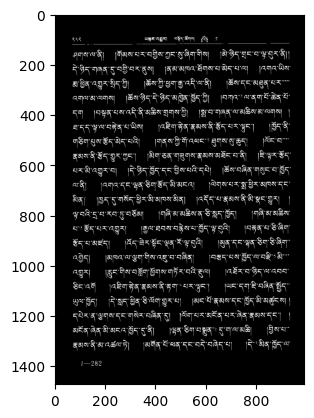

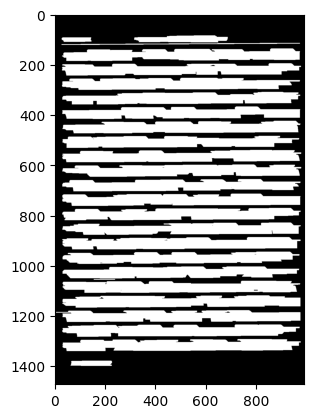

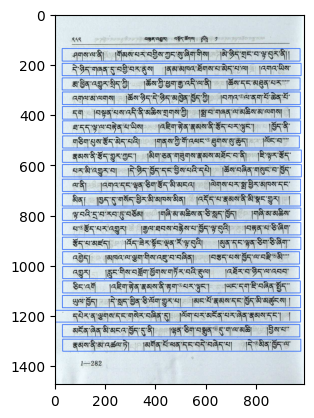

In [34]:
line_contours = list(get_line_contours(img, imshow=True))

In [43]:
def get_lines(img):
    for x, y, w, h in get_line_contours(img):
        yield img[y:y+h, x:x+w].copy()

In [44]:
lines = list(get_lines(img))

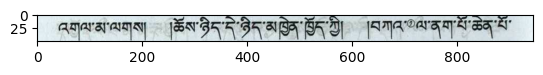

In [48]:
plt.imshow(lines[3])
plt.show()

In [109]:
def create_template(image_fn, template_name, n_line, x, w):
    img = cv2.imread(str(image_fn))
    lines = list(get_lines(img))
    line = lines[n_line-1]
    plt.imshow(line)
    plt.show()
    template = line[0:line.shape[0], x:x+w]
    plt.imshow(template)
    plt.show()

    template_fn = config.TEMPLATES_PATH / f"{template_name}.png"
    cv2.imwrite(str(template_fn), template)

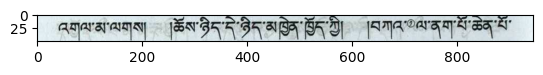

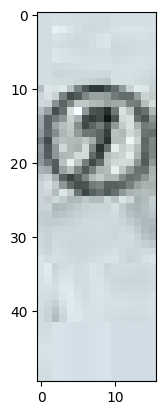

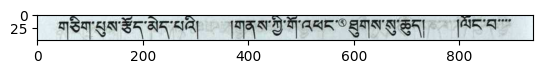

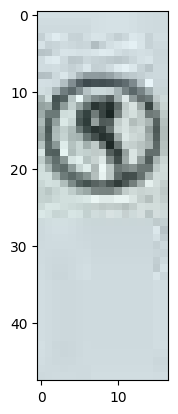

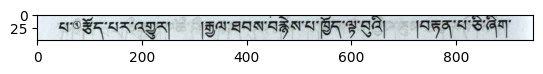

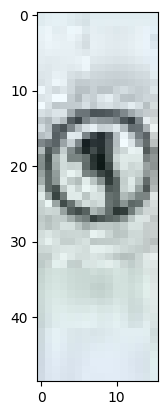

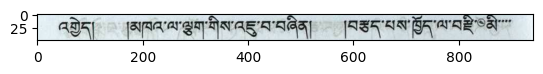

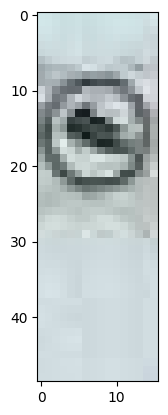

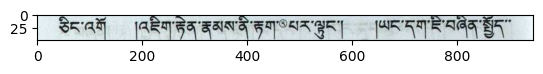

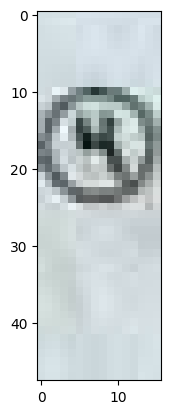

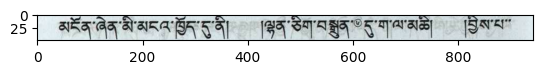

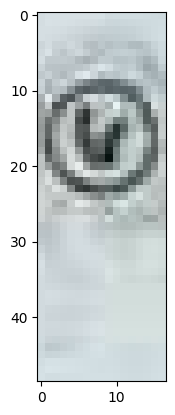

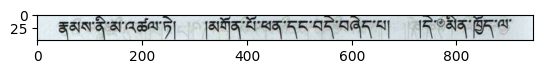

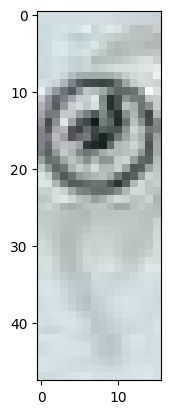

In [205]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460320.jpg"
create_template(image_fn, "01", 4, 705, 16)
create_template(image_fn, "02", 7, 571, 17)
create_template(image_fn, "03", 13, 68, 16)
create_template(image_fn, "04", 15, 836, 16)
create_template(image_fn, "05", 17, 461, 16)
create_template(image_fn, "06", 20, 602, 17)
create_template(image_fn, "07", 21, 763, 16)

In [206]:
def match_template(img, template, imshow=False):
    """find the given template on the image

    Returns:
        - loc ([(x, y), ...]: list of matched template (x,y)
    """
    img_copy = img.copy()
    h, w, _ = template.shape
    
    res = cv2.matchTemplate(img_copy, template, cv2.TM_CCOEFF_NORMED)
    
    # Set a threshold
    threshold = 0.8
    loc = np.where(res >= threshold)
    
    if imshow:
        # Draw rectangles around matched regions
        for pt in zip(*loc[::-1]):
            cv2.rectangle(img_copy, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
        if loc:
            plt.imshow(img_copy)
            plt.show()
    return zip(*loc[::-1])

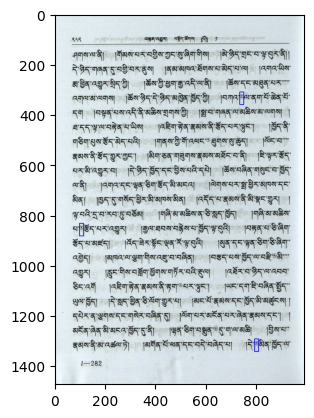

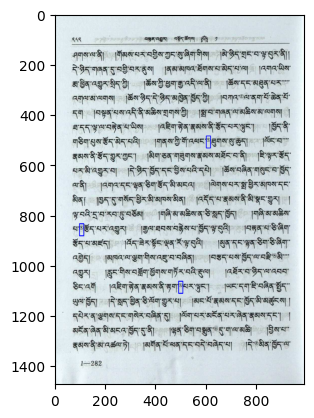

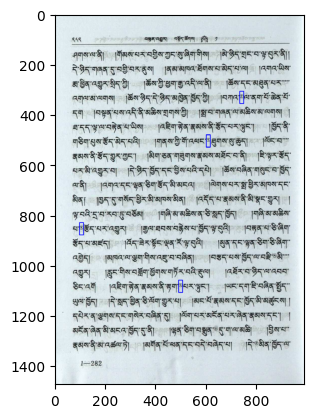

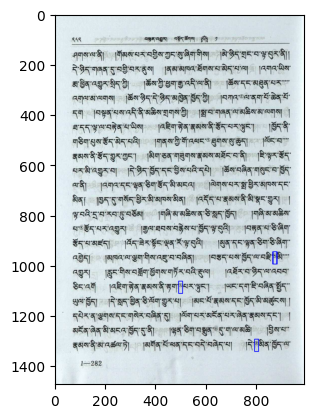

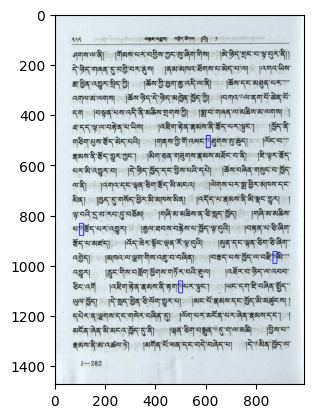

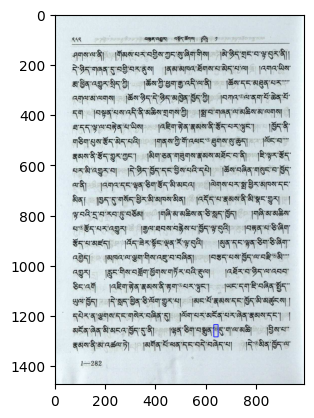

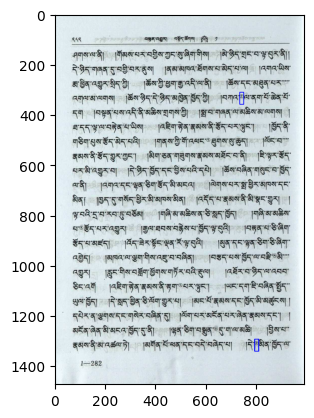

In [207]:
def test_template(image_fn):
    img = cv2.imread(str(image_fn))
    for template_fn in sorted(config.TEMPLATES_PATH.iterdir()):
        if not template_fn.name.endswith(".png"): continue
        template = cv2.imread(str(template_fn))
        match_template(img, template, imshow=True)

test_template(image_fn)

In [231]:
def find_pedurma_note_number(image_fn, imshow=False):

    def find_unique_matches(matches):
        matches.sort(key=lambda x: x[0])
        grouped_matches = []
        similar_matches = [matches[0]]
        prev_match = matches[0]
        for match in matches[1:]:
            if abs(match[0]-prev_match[0]) > 10 and abs(match[1]-prev_match[1]) > 10:
                grouped_matches.append(similar_matches)
                similar_matches = []
            similar_matches.append(match)
            prev_match = match

        if similar_matches:
            grouped_matches.append(similar_matches)

        unique_matches = []
        for matches in grouped_matches:
            unique_matches.append(matches[0])

        return unique_matches

                
    img = cv2.imread(str(image_fn))
    all_matches = []
    for template_fn in sorted(config.TEMPLATES_PATH.iterdir()):
        if not template_fn.name.endswith(".png"): continue
        template = cv2.imread(str(template_fn))
        matches = match_template(img, template)
        all_matches.extend(matches)

    unique_matches = find_unique_matches(all_matches)

    if imshow:
        h, w, _ = template.shape
        for x, y in unique_matches:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        plt.imshow(img)
        plt.show()
    return unique_matches

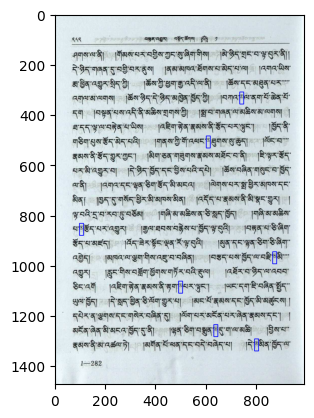

In [232]:
matches = find_pedurma_note_number(image_fn, imshow=True)

In [107]:
x, y, w, h = lines[3]
line = img[y:y+h, x:x+w]
line = line.copy()
template = line[0:line.shape[0], 705:722]
cv2.imwrite("01_tpl.png", template)

True

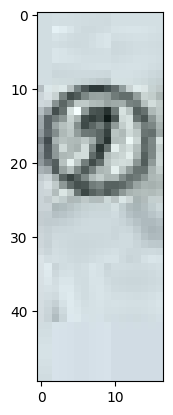

In [108]:
tlp = cv2.imread("01_tpl.png")
plt.imshow(tlp)

(48, 941, 3)
(50, 17, 3)
(48, 17, 3)
(array([], dtype=int64), array([], dtype=int64))
[]


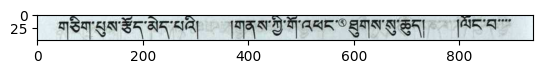

In [124]:
x, y, w, h = lines[6]
line = img[y:y+h, x:x+w]
print(line.shape)
match_template(line, template, imshow=True)

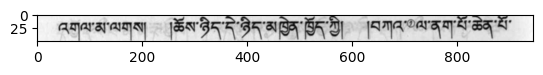

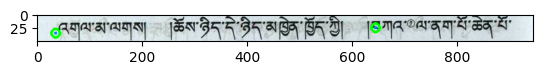

In [74]:
line = img[y:y+h, x:x+w]
line = line.copy()
line_gray = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)
line_gray_blurred = cv2.GaussianBlur(line_gray, (3, 3), 0)
plt.imshow(line_gray_blurred, cmap="gray")
plt.show()

# Detect circles using Hough Transform
circles = cv2.HoughCircles(line_gray_blurred, cv2.HOUGH_GRADIENT, 10, 500,
                           param1=1, param2=1, minRadius=8, maxRadius=8)
# Filter circles based on expected size and draw them
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        # Draw the circle in the output image
        cv2.circle(line, (x, y), r, (0, 255, 0), 4)
        # Optionally, draw the centroid of the circle
        cv2.rectangle(line, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1)
plt.imshow(line)
plt.show()